In [160]:
import gym
from gym import spaces
import pickle
import pandas as pd
import numpy as np
import random
import tkinter as tk
from tkinter import *
import matplotlib.pyplot as plt
import torch
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
# from transformers import InformerConfig, InformerForPrediction
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler


In [491]:
rl_data = pickle.load('rl_data.pkl', 'wb')
minmax_scaler = pickle.load(open('minmax_scaler.pkl', 'rb'))


In [597]:
class VesselEnvironment(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, rl_data, model_path="new_3_final.pt", model_loc_path="longlat_0_checkpoint4.pt", scaler=minmax_scaler):
        self.rl_data = rl_data
        self.trip_id = 0
        # load best 1% trips to calculate reward1
        self.hn_top = pd.read_csv("H2N_top1.csv")
        self.nh_top = pd.read_csv("N2H_top1.csv")
        # set scaler
        self.minmax_scaler = scaler
        # get device
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
        # load forecasting models
        configuration = TimeSeriesTransformerConfig(prediction_length=5,
        context_length=18, input_size=2, num_time_features=1,
        num_dynamic_real_features = 14, num_static_real_features = 4,
        return_dict = True)
        model = TimeSeriesTransformerForPrediction(configuration).to(self.device)
        model.load_state_dict(torch.load(model_path,map_location=torch.device(self.device)))
        model.eval()
        self.model = model

        configuration_loc = TimeSeriesTransformerConfig(prediction_length=5,
        context_length=18, input_size=2, num_time_features=1,
        num_dynamic_real_features = 14, num_static_real_features = 4,
        return_dict = True)
        model_loc = TimeSeriesTransformerForPrediction(configuration_loc).to(self.device)
        model_loc.load_state_dict(torch.load(model_loc_path,map_location=torch.device(self.device)))
        model_loc.eval()
        self.model_loc = model_loc

        # initialize values
        self.current_step = 25
        self.reward_cum = 0
        self.obs = np.zeros([1,19], dtype=np.float64)
        self.actions = np.zeros([1,3], dtype=np.float64)

    def _get_observation(self):
        return self.obs[-1]
    
    def reset(self, seed=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        if(self.trip_id < len(rl_data)-1):
            self.trip_id = self.trip_id + 1
        else:
            self.trip_id = 1
        self.data = self.rl_data[self.trip_id]["observations"]
        self.current_step = 25
        self.obs = self.rl_data[self.trip_id]["observations"][0:25]
        self.actions = self.rl_data[self.trip_id]["actions"][0:25]
        # get direction and other static features
        self.direction = self.rl_data[self.trip_id]["observations"][0, 12]
        self.statics = self.rl_data[self.trip_id]["observations"][0, 12:16]
        if self.direction==1:
            self.top1 = self.hn_top
            self.goal_long_t, self.goal_lat_t = np.float64(0.9965111208024382), np.float64(0.7729570345408661)
        else:
            self.top1 = self.nh_top
            self.goal_long_t, self.goal_lat_t = np.float64(0.0023259194650222526), np.float64(0)

        # calculate the cumulative reward
        self.reward_cum = np.sum(self.rl_data[self.trip_id]["rewards"][:25, :])/4

        return self._get_observation(), {}

    def _take_action(self, action):
        # get actions
        speed, heading, mode = action
        heading = heading * 360
        mode = int(mode>0.5)
        if self.current_step < self.rl_data[self.trip_id]["observations"].shape[0]:
            future_obs = self.rl_data[self.trip_id]["observations"][self.current_step].copy()
        else:
            future_obs = self.rl_data[self.trip_id]["observations"][-1].copy()
        obs = self.obs.copy()
        actions = self.actions.copy()
        # obs_cols = ["Time2", "turn", "acceleration",
        #    'change_x_factor', 'change_y_factor', "distance",
        #    'current', 'rain', 'snowfall', 'wind_force', 'wind_direc', "resist_ratio",
        #    "is_weekday", 'direction', "season", "hour", 
        #    "FC", "SOG", "LATITUDE", 'LONGITUDE',
        #    ], 
        # action_cols = ["SPEED", "HEADING", "MODE"]
        # time_feature = ["Time2", "SPEED", "HEADING", "MODE", "turn", "acceleration",
        #     "distance", 'current', 'rain', 'snowfall', 'wind_force', 'wind_direc', "resist_ratio", 
        #     "FC", "SOG"]
        # static_categorical_feature = ["is_weekday", 'direction',"season", "hour"]
        # y_cols = ["FC2", "SOG4"]
        # dynamic_real_feature = [["Time2", "SPEED", "HEADING", "MODE", "turn", "acceleration",
        #     "change_x_factor", "change_y_factor",
        #     "distance", 'current', 'rain', 'snowfall', 'wind_force', 'wind_direc', "resist_ratio"]
        
        # get model inputs
        past_time_features = np.zeros([25, 15])
        past_time_features[:, 0] = obs[-25:, 0]
        past_time_features[:, 1:4] = actions[-25:, ] # speed, heading, mode
        past_time_features[:, 4:13] = obs[-25:, [1,2,5,6,7,8,9,10,11]]
        past_time_features[:, 13:15] = obs[-25:, 16:18]

        future_time_features = past_time_features[-5:].copy()
        future_time_features[:, 0] = future_time_features[:, 0] + 5
        future_time_features[0, [1,2,3]] = speed, heading, mode
        future_time_features[0, 4] = heading - past_time_features[-1, 2]

        past_values = obs[-25:, [16, 17]].copy()
        past_values[:, 0] = (past_values[:, 0])**2
        past_values[:, 1] = (past_values[:, 1])**4

        past_time_features_loc = past_time_features.copy()
        past_time_features_loc[:, 8:] = past_time_features_loc[:, 6:-2]
        past_time_features_loc[:, [6,7]] = obs[-25:, [3,4]]
        future_time_features_loc = future_time_features.copy()
        future_time_features_loc[:, 8:] = future_time_features_loc[:, 6:-2]
        future_time_features_loc[:, [6,7]] = past_time_features_loc[-5:, [3,4]].copy()
        change_x = np.cos((heading+90) * np.pi / 180)
        change_y = np.sin((heading-90) * np.pi / 180)
        future_time_features_loc[0, [6,7]] = change_x, change_y
        past_values_loc = obs[-25:, -2:]

        # predict fc, sog, long, lat
        fc, sog = self._predict(past_values, past_time_features, future_time_features)
        lat,long = self._predict_loc(past_values_loc, past_time_features_loc, future_time_features_loc)

        # generate next observation and update obs list
        new_observe = future_obs
        new_observe[0] = future_time_features[0, 0]
        new_observe[1:3] = future_time_features[0, 4:6]
        new_observe[3:5] = change_x, change_y 
        distance = ((self.goal_long_t-long)**2 + \
                             (self.goal_lat_t-lat)**2 )**0.5
        new_observe[5] = distance
        new_observe[6:16] = future_obs[6:16]
        new_observe[[16,17,18,19]] = fc, sog, lat, long
        # new_observe[16:19]] = future_obs[16:19]

        # append new observations and actions
        self.obs = np.append(self.obs, np.expand_dims(new_observe, 0), axis=0)
        self.actions = np.append(self.actions, np.expand_dims(action, 0), axis=0)

        return fc ,sog, lat, long

    def _predict_loc(self, past_values, past_time_features, future_time_features):
        self.model_loc.eval()
        self.model_loc.to(self.device)
        # add 1 dimension to the inputs
        future_time_features = torch.from_numpy(np.expand_dims(future_time_features, 0)).float().to(self.device)
        past_values = torch.from_numpy(np.expand_dims(past_values, 0)).float().to(self.device)
        past_time_features = torch.from_numpy(np.expand_dims(past_time_features, 0)).float().to(self.device)
        static_real_features = torch.from_numpy(np.expand_dims(self.statics, 0)).float().to(self.device)
        past_observed_mask = torch.ones(past_values.shape).to(self.device)
        
        with torch.no_grad():
            outputs = self.model_loc.generate(past_values=past_values, past_time_features=past_time_features,
                    static_real_features=static_real_features, past_observed_mask=past_observed_mask,
                    future_time_features=future_time_features)
        outputs = outputs.sequences.mean(dim=1).detach().cpu().numpy()
        lat, long= outputs[0,0,0], outputs[0,0,1]
        return lat, long    

    def _predict(self, past_values, past_time_features, future_time_features):
        self.model.eval()
        self.model.to(self.device)
        future_time_features = torch.from_numpy(np.expand_dims(future_time_features, 0)).float().to(self.device)
        past_values = torch.from_numpy(np.expand_dims(past_values, 0)).float().to(self.device)
        past_time_features = torch.from_numpy(np.expand_dims(past_time_features, 0)).float().to(self.device)
        static_real_features = torch.from_numpy(np.expand_dims(self.statics, 0)).float().to(self.device)
        past_observed_mask = torch.ones(past_values.shape).to(self.device)
    
        # make prediction
        with torch.no_grad():
            outputs = self.model.generate(past_values=past_values, past_time_features=past_time_features,
                    static_real_features=static_real_features, past_observed_mask=past_observed_mask,
                    future_time_features=future_time_features)
        outputs = outputs.sequences.mean(dim=1).detach().cpu().numpy()
        fc2, sog4 = outputs[0,0,0], outputs[0,0,1],
        return max(0, min(1, fc2**0.5)), max(0, min(1, sog4**0.25))

    def _get_reward(self, long, lat, fc):
        # reward 1 distance to the top 1
        reward1 = ((long-self.top1.loc[self.current_step, "LONGITUDE"])**2 + (lat-self.top1.loc[self.current_step, "LATITUDE"])**2 )**0.5
        # reward 2 fc and done reward
        reward2 = -fc
        # reward 3 mimicc reward
        if self.current_step < len(self.data):
            reward3 = ((long-self.data[self.current_step, 19])**2 + (lat-self.data[self.current_step, 18])**2 )**0.5
        else:
            reward3 = ((long-self.data[-1, 19])**2 + (lat-self.data[-1, 18])**2 )**0.5
        # reward 4 timeout reward
        reward4 = 0
        if self.current_step > 100:
            reward4 = -0.1*((self.current_step-90)//10)
        return (reward1 + reward2 + reward3 + reward4) / 3

    def step(self, action, test=False):
        obs= self._get_observation()
        self.current_step += 1

        fc, sog, lat, long = self._take_action(action)
        if test:
            return fc, sog, lat, long
        # get done and termination
        done = (((long-self.goal_long_t)**2 + (lat-self.goal_lat_t)**2) < 1e-2)
        termination =  self.current_step >= 124

        reward = self._get_reward(long, lat, fc)
        self.reward_cum = self.reward_cum + reward

        if done:
            reward = reward+1/3
        return obs, self.reward_cum, done, termination, {}


    def _inv_transform_location(self, lat, long):
        array = np.zeros([1, 12],dtype=np.float64)
        array[0, [7,8]] = lat, long
        lat, long = self.minmax_scaler.inverse_transform(array)[0,[7, 8]]
        return lat, long

    def _transform_value(self, vals, indexes):
        array = np.zeros([1, 12],dtype=np.float64)
        for i in range(len(indexes)):
            array[0, indexes[i]] = vals[i]
        transformed_val = self.minmax_scaler.transform(array)[0, [indexes]]
        return transformed_val[0]


    def render(self, mode="human"):
        lat, long = self.obs[:, -2].copy(), self.obs[:, -1].copy()
        for i in range(len(lat)):
            lat[i], long[i] = self._inv_transform_location(lat[i],long[i])
        # generate the figure and plot object which will be linked to the root element
        fig, ax = plt.subplots()
        fig.set_size_inches(3.5, 3.5)
        # ax.scatter(long_lat[:,1],long_lat[:,0],c=stw, s=1)
        ax.scatter(long,lat, s=1)
        # ax.set_xlim(xmin = -124.0, xmax= -123.2)
        # ax.set_ylim(ymin=49.15, ymax=49.45)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7,rotation=90)
        # ax.axis("off")
        plt.subplots_adjust(top=0.925,     # Further fix clipping of text in the figure
                            bottom=0.16,
                            left=0.11,
                            right=0.90,
                            hspace=0.2,
                            wspace=0.2)
        # canvas = FigureCanvasTkAgg(fig,master=root_window)
        # canvas.draw()
        # canvas.get_tk_widget().place(relx=0.15, rely=0.15)

        # root_window.mainloop()

In [549]:
with open('rl_data.pkl', 'rb') as handle:
    rl_data = pickle.load(handle)

In [550]:
# transform_cols = [ 'current', 'rain', 'snowfall', "pressure", 'wind_force', "resist_ratio",
#        'FC', "LATITUDE", 'LONGITUDE', 'SOG', "DEPTH", "SPEED"]
fcs = []
sogs = []
longs = []
lats = []
for i in range(6):
    array = np.zeros((len(rl_data[i]["observations"]), 12))
    array[:, 6] = rl_data[i]["observations"][:, -4]
    array[:, 9] = rl_data[i]["observations"][:, -3]
    array[:, 7] = rl_data[i]["observations"][:, -2]
    array[:, 8] = rl_data[i]["observations"][:, -1]
    minmax_scaler = pickle.load(open('minmax_scaler.pkl', 'rb'))
    array = minmax_scaler.inverse_transform(array)
    fcs.append(array[:, 6])
    sogs.append(array[:, 9])
    lats.append(array[:, 7])
    longs.append(array[:, 8])

In [598]:
env = VesselEnvironment(rl_data[:7], model_path="fc_2_final.pt", model_loc_path="longlat_3_final.pt", scaler=minmax_scaler)
env.reset()
fc_predicted = []
sog_predicted = []
lat_predicted = []
long_predicted = []
for i in range(1,7):
    length = rl_data[i]["observations"].shape[0]
    fc = np.zeros((length))
    sog =  np.zeros((length))
    lat = np.zeros((length))
    long = np.zeros((length))
    for j in range(25, length):
        res = env.step(rl_data[i]["actions"][j], test=True)
    #     # print(res)
        fc[j], sog[j], lat[j], long[j] = res[0], res[1], res[2], res[3]
    array1 = np.zeros((length, 12))
    array1[:, 6] = fc
    array1[:, 9] = sog
    array1[:, 7] = lat
    array1[:, 8] = long
    minmax_scaler = pickle.load(open('minmax_scaler.pkl', 'rb'))
    array1 = minmax_scaler.inverse_transform(array1)
    fc_predicted.append(array1[:, 6])
    sog_predicted.append(array1[:, 9])
    lat_predicted.append(array1[:, 7])
    long_predicted.append(array1[:, 8])
    if(i<6):
        env.reset()


In [577]:
# for i in range(6):
#     length = len(fc_predicted[i])
#     array = np.zeros((length, 10))
#     array[:, 5] = fc_predicted[i]
#     array[:, 6] = lat_predicted[i]
#     array[:, 7] = long_predicted[i]
#     pickle.load(open('minmax_scaler.pkl', 'rb'))
#     array = minmax_scaler.inverse_transform(array)
#     fc_predicted[i] = (array[:, 5])
#     lat_predicted[i] = (array[:, 6])
#     long_predicted[i] = (array[:, 7])

In [591]:
from  sklearn.metrics import mean_squared_error
plt.rcParams.update({'font.size': 8})

i=4
def plot(i):
    fig = plt.figure()
    grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)

    ax1 = plt.subplot(grid[0, 0])
    ax2 = plt.subplot(grid[0, 1:])
    ax3 = plt.subplot(grid[1, :1])
    ax4 = plt.subplot(grid[1, 1:])
    mse1 = mean_squared_error(fc_predicted[i][25:], fcs[i+1][25:], squared=False)
    mse2 = mean_squared_error(long_predicted[i][25:], longs[i+1][25:], squared=False)
    mse3 = mean_squared_error(lat_predicted[i][25:], lats[i+1][25:], squared=False)
    mse4 = mean_squared_error(sog_predicted[i][25:], sogs[i+1][25:], squared=False)

    ax1.plot(range(25, len(fc_predicted[i])), fc_predicted[i][25:], label='predictions'.format(i=2))
    ax1.plot(range(25, len(fc_predicted[i])), fcs[i+1][25:], label='actuals'.format(i=1))
    ax1.legend(loc='best')
    ax1.set_title("fc, rmse: {}".format(mse1))
    ax2.plot(range(25, len(fc_predicted[i])), long_predicted[i][25:], label='predictions'.format(i=2))
    ax2.plot(range(25, len(fc_predicted[i])), longs[i+1][25:], label='actuals'.format(i=1))
    ax2.legend(loc='best')
    ax2.set_title("longitude, rmse: {}".format(mse2))
    ax3.plot(range(25, len(fc_predicted[i])), lat_predicted[i][25:], label='predictions'.format(i=2))
    ax3.plot(range(25, len(fc_predicted[i])), lats[i+1][25:], label='actuals'.format(i=1))
    ax3.legend(loc='best')
    ax3.set_title("latitude, rmse: {}".format(mse3))
    ax4.plot(range(25, len(sog_predicted[i])), sog_predicted[i][25:], label='predictions'.format(i=2))
    ax4.plot(range(25, len(sog_predicted[i])), sogs[i+1][25:], label='actuals'.format(i=1))
    ax4.legend(loc='best')
    ax4.set_title("sog, rmse: {}".format(mse4))

    plt.savefig("env_test_trip{}.jpg".format(i+1))

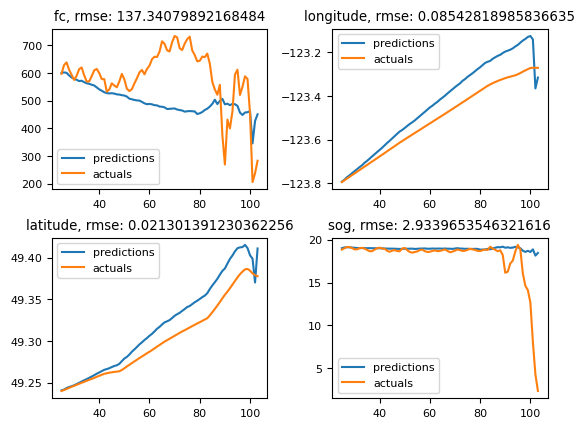

In [604]:
plot(4)

In [418]:
env = VesselEnvironment(rl_data, model_path="new1_2_final.pt", model_loc_path="longlat_1_checkpoint9.pt", scaler=minmax_scaler)
env.reset()


(array([ 2.50000000e+01,  1.00000000e-01, -9.91203073e-04,  8.22752358e-01,
         1.88435445e-01,  9.76817730e-01,  4.30221104e-01,  0.00000000e+00,
         0.00000000e+00,  1.47476876e-01,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  2.50000000e-01,  2.91666667e-01,
         5.15064406e-01,  1.81550126e-01,  2.19072540e-01]),
 {})

In [419]:
i=1
j=24

In [457]:
time_feature = ["Time2"]
dynamic_real_feature = [ "SOG", "HEADING", "MODE", "turn", "acceleration",
       'disp_x', 'disp_y', "distance",
       'current', 'rain', 'snowfall', 'wind_force', 'wind_direc', "SOG4", "FC"]
static_categorical_feature = ["is_weekday", 'direction', 'adversarial', "season", "hour"]
y_cols = ['FC2', "LATITUDE", 'LONGITUDE']
df[df.trip_id==4][['Time2', 'disp_x', 'disp_y', "LATITUDE", "LONGITUDE"]].reset_index(drop=True).iloc[j-10:j]

,Time2,disp_x,disp_y,LATITUDE,LONGITUDE
93,94.0,0.454714,0.692235,0.711879,0.933711
94,95.0,0.404281,0.726349,0.729570,0.939526
95,96.0,0.478892,0.691607,0.748104,0.945050
96,97.0,0.489116,0.683190,0.766217,0.951301
97,98.0,0.678064,0.480096,0.783067,0.958424
98,99.0,0.586144,0.425859,0.795282,0.967437
99,100.0,0.519183,0.363536,0.806234,0.975432
100,101.0,0.578122,0.061783,0.814238,0.982701
101,102.0,0.467697,-0.291116,0.813816,0.990406
102,103.0,0.115432,-0.496041,0.805392,0.996075


In [458]:
j=j+1
res = env.step(rl_data[i]["actions"][j], test=True)

tensor([[[9.5000e+01, 7.7023e-01, 3.6903e-01],
         [9.6000e+01, 6.4247e-01, 2.4277e-01],
         [9.7000e+01, 5.5113e-01, 2.2043e-01],
         [9.8000e+01, 5.1402e-01, 2.3317e-01],
         [9.9000e+01, 3.1882e-01, 4.3721e-01],
         [1.0000e+02, 1.1614e-01, 3.7989e-01],
         [1.0100e+02, 6.0930e-02, 2.7259e-01],
         [1.0200e+02, 1.4203e-02, 1.5607e-01],
         [1.0300e+02, 4.1217e-03, 9.0767e-02],
         [1.0400e+02, 4.5302e-01, 4.3292e-01]]])
tensor([[[1.0500e+02, 1.0329e-01, 4.5834e-01]]])
tensor([[[0.0564, 0.0295],
         [0.0501, 0.0209],
         [0.0447, 0.0135],
         [0.0358, 0.0074],
         [0.0236, 0.0042],
         [0.0139, 0.0029],
         [0.0067, 0.0023],
         [0.0025, 0.0023],
         [0.0025, 0.0023],
         [0.0025, 0.0023]]])
